In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Load Data

In [3]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    # we took normalize values from ImageNet dataset as we will use transfer learning later
    transforms.Normalize(mean=[0.485,0.456,0.405],std=[0.229,0.224,0.225])
])

In [4]:
dataset_path = "./dataset"
dataset=datasets.ImageFolder(root=dataset_path,transform=image_transforms)
len(dataset)

2300

In [5]:
class_names=dataset.classes
class_names

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [6]:
num_classes=len(dataset.classes)
num_classes

6

In [7]:
train_size=int(0.75*len(dataset))

val_size=int(len(dataset)-train_size)

train_size,val_size

(1725, 575)

In [8]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(dataset,[train_size,val_size])

In [9]:
train_loader=DataLoader(train_dataset,batch_size=32, shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=32, shuffle=True)

In [10]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [11]:
images[1],labels[1]

(tensor([[[-2.0323, -2.0323, -2.0323,  ..., -2.0323, -2.0323, -2.0323],
          [-2.0323, -2.0323, -2.0323,  ..., -2.0323, -2.0323, -2.0323],
          [-2.0323, -2.0323, -2.0323,  ..., -2.0323, -2.0323, -2.0323],
          ...,
          [-2.0323, -2.0323, -2.0323,  ..., -2.0323, -2.0323, -2.0323],
          [-2.0323, -2.0323, -2.0323,  ..., -2.0323, -2.0323, -2.0323],
          [-2.0323, -2.0323, -2.0323,  ..., -2.0323, -2.0323, -2.0323]],
 
         [[-1.9482, -1.9482, -1.9482,  ..., -1.9482, -1.9482, -1.9482],
          [-1.9482, -1.9482, -1.9482,  ..., -1.9482, -1.9482, -1.9482],
          [-1.9482, -1.9482, -1.9482,  ..., -1.9482, -1.9482, -1.9482],
          ...,
          [-1.9482, -1.9482, -1.9482,  ..., -1.9482, -1.9482, -1.9482],
          [-1.9482, -1.9482, -1.9482,  ..., -1.9482, -1.9482, -1.9482],
          [-1.9482, -1.9482, -1.9482,  ..., -1.9482, -1.9482, -1.9482]],
 
         [[-1.7129, -1.7129, -1.7129,  ..., -1.7129, -1.7129, -1.7129],
          [-1.7129, -1.7129,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.2958608].


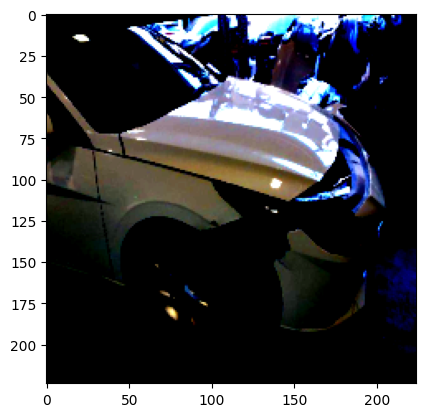

In [12]:
# rearrange dimension
plt.imshow(images[1].permute(1,2,0).squeeze())
plt.show()

### Model 1: CNN

In [13]:
class CarClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224) 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)           
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

In [14]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")
            
            running_loss += loss.item() * images.size(0)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                
            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")
            
    end = time.time()
    print(f"Execution time: {end - start} seconds")     
    
    return all_labels, all_predictions

In [15]:
# Instantiate the model, loss function, and optimizer
model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)
# We can see overfitting training loss is decreasing but val loss is not decreasing

Batch: 10, Epoch: 1, Loss: 1.79
Batch: 20, Epoch: 1, Loss: 1.65
Batch: 30, Epoch: 1, Loss: 1.70
Batch: 40, Epoch: 1, Loss: 1.61
Batch: 50, Epoch: 1, Loss: 1.33
Epoch [1/10], Avg Loss: 1.7171
*** Validation Accuracy: 44.17% ***
Batch: 10, Epoch: 2, Loss: 1.42
Batch: 20, Epoch: 2, Loss: 1.27
Batch: 30, Epoch: 2, Loss: 1.25
Batch: 40, Epoch: 2, Loss: 1.46
Batch: 50, Epoch: 2, Loss: 1.07
Epoch [2/10], Avg Loss: 1.3080
*** Validation Accuracy: 45.04% ***
Batch: 10, Epoch: 3, Loss: 1.20
Batch: 20, Epoch: 3, Loss: 1.39
Batch: 30, Epoch: 3, Loss: 1.31
Batch: 40, Epoch: 3, Loss: 1.38
Batch: 50, Epoch: 3, Loss: 1.39
Epoch [3/10], Avg Loss: 1.1922
*** Validation Accuracy: 48.52% ***
Batch: 10, Epoch: 4, Loss: 1.26
Batch: 20, Epoch: 4, Loss: 1.09
Batch: 30, Epoch: 4, Loss: 0.97
Batch: 40, Epoch: 4, Loss: 0.87
Batch: 50, Epoch: 4, Loss: 0.99
Epoch [4/10], Avg Loss: 1.0917
*** Validation Accuracy: 50.43% ***
Batch: 10, Epoch: 5, Loss: 0.98
Batch: 20, Epoch: 5, Loss: 0.82
Batch: 30, Epoch: 5, Loss: 0

### Model 2: CNN with Regularization

In [16]:
class CarClassifierCNNWithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224) 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)           
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

In [17]:
class CarClassifierCNNWithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224) 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)           
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

In [18]:
model = CarClassifierCNNWithRegularization(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

all_labels, all_predictions = train_model(model, criterion, optimizer,  epochs=10)

Batch: 10, Epoch: 1, Loss: 17.26
Batch: 20, Epoch: 1, Loss: 7.87
Batch: 30, Epoch: 1, Loss: 3.47
Batch: 40, Epoch: 1, Loss: 1.81
Batch: 50, Epoch: 1, Loss: 1.68
Epoch [1/10], Avg Loss: 8.3461
*** Validation Accuracy: 38.61% ***
Batch: 10, Epoch: 2, Loss: 1.66
Batch: 20, Epoch: 2, Loss: 1.63
Batch: 30, Epoch: 2, Loss: 1.51
Batch: 40, Epoch: 2, Loss: 1.45
Batch: 50, Epoch: 2, Loss: 1.50
Epoch [2/10], Avg Loss: 1.4758
*** Validation Accuracy: 46.96% ***
Batch: 10, Epoch: 3, Loss: 1.08
Batch: 20, Epoch: 3, Loss: 1.57
Batch: 30, Epoch: 3, Loss: 1.40
Batch: 40, Epoch: 3, Loss: 1.30
Batch: 50, Epoch: 3, Loss: 1.29
Epoch [3/10], Avg Loss: 1.3056
*** Validation Accuracy: 52.35% ***
Batch: 10, Epoch: 4, Loss: 1.28
Batch: 20, Epoch: 4, Loss: 1.46
Batch: 30, Epoch: 4, Loss: 1.23
Batch: 40, Epoch: 4, Loss: 1.17
Batch: 50, Epoch: 4, Loss: 0.97
Epoch [4/10], Avg Loss: 1.2545
*** Validation Accuracy: 50.09% ***
Batch: 10, Epoch: 5, Loss: 1.02
Batch: 20, Epoch: 5, Loss: 1.10
Batch: 30, Epoch: 5, Loss: 

### Model 3: Transfer Learning with EfficientNet

In [19]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')
        
        for param in self.model.parameters():
            param.requires_grad= False
        
        in_features = self.model.classifier[1].in_features
        
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features,num_classes)
        )
    def forward(self, x):
        x = self.model(x)
        return x

In [20]:
model = CarClassifierEfficientNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer,  epochs=10)

Batch: 10, Epoch: 1, Loss: 1.65
Batch: 20, Epoch: 1, Loss: 1.53
Batch: 30, Epoch: 1, Loss: 1.45
Batch: 40, Epoch: 1, Loss: 1.30
Batch: 50, Epoch: 1, Loss: 1.32
Epoch [1/10], Avg Loss: 1.5007
*** Validation Accuracy: 53.57% ***
Batch: 10, Epoch: 2, Loss: 1.19
Batch: 20, Epoch: 2, Loss: 1.14
Batch: 30, Epoch: 2, Loss: 1.29
Batch: 40, Epoch: 2, Loss: 1.06
Batch: 50, Epoch: 2, Loss: 1.07
Epoch [2/10], Avg Loss: 1.1412
*** Validation Accuracy: 62.61% ***
Batch: 10, Epoch: 3, Loss: 1.00
Batch: 20, Epoch: 3, Loss: 0.94
Batch: 30, Epoch: 3, Loss: 1.01
Batch: 40, Epoch: 3, Loss: 0.97
Batch: 50, Epoch: 3, Loss: 0.89
Epoch [3/10], Avg Loss: 1.0103
*** Validation Accuracy: 64.70% ***
Batch: 10, Epoch: 4, Loss: 1.12
Batch: 20, Epoch: 4, Loss: 1.07
Batch: 30, Epoch: 4, Loss: 0.97
Batch: 40, Epoch: 4, Loss: 0.87
Batch: 50, Epoch: 4, Loss: 0.92
Epoch [4/10], Avg Loss: 0.9490
*** Validation Accuracy: 64.52% ***
Batch: 10, Epoch: 5, Loss: 1.16
Batch: 20, Epoch: 5, Loss: 0.83
Batch: 30, Epoch: 5, Loss: 0

### Model 4: Transfer Learning With ResNet

In [21]:
# Load the pre-trained ResNet model
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True            
            
        # Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [22]:
model = CarClassifierResNet(num_classes=num_classes,dropout_rate=0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.005)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.05
Batch: 20, Epoch: 1, Loss: 0.75
Batch: 30, Epoch: 1, Loss: 1.09
Batch: 40, Epoch: 1, Loss: 0.66
Batch: 50, Epoch: 1, Loss: 0.88
Epoch [1/10], Avg Loss: 0.8885
*** Validation Accuracy: 71.48% ***
Batch: 10, Epoch: 2, Loss: 0.50
Batch: 20, Epoch: 2, Loss: 0.44
Batch: 30, Epoch: 2, Loss: 0.63
Batch: 40, Epoch: 2, Loss: 0.67
Batch: 50, Epoch: 2, Loss: 0.63
Epoch [2/10], Avg Loss: 0.5212
*** Validation Accuracy: 77.39% ***
Batch: 10, Epoch: 3, Loss: 0.38
Batch: 20, Epoch: 3, Loss: 0.24
Batch: 30, Epoch: 3, Loss: 0.63
Batch: 40, Epoch: 3, Loss: 0.40
Batch: 50, Epoch: 3, Loss: 0.44
Epoch [3/10], Avg Loss: 0.4415
*** Validation Accuracy: 74.96% ***
Batch: 10, Epoch: 4, Loss: 0.57
Batch: 20, Epoch: 4, Loss: 0.33
Batch: 30, Epoch: 4, Loss: 0.36
Batch: 40, Epoch: 4, Loss: 0.27
Batch: 50, Epoch: 4, Loss: 0.25
Epoch [4/10], Avg Loss: 0.3416
*** Validation Accuracy: 78.96% ***
Batch: 10, Epoch: 5, Loss: 0.17
Batch: 20, Epoch: 5, Loss: 0.40
Batch: 30, Epoch: 5, Loss: 1

### Model Evaluation Using Confusion Matrix and Classification Report

In [23]:
from sklearn.metrics import classification_report

report = classification_report(labels, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.76      0.83       125
           1       0.66      0.94      0.77       103
           2       0.99      0.83      0.90       125
           3       0.84      0.72      0.78        80
           4       0.57      0.74      0.64        65
           5       0.86      0.74      0.80        77

    accuracy                           0.80       575
   macro avg       0.81      0.79      0.79       575
weighted avg       0.83      0.80      0.80       575



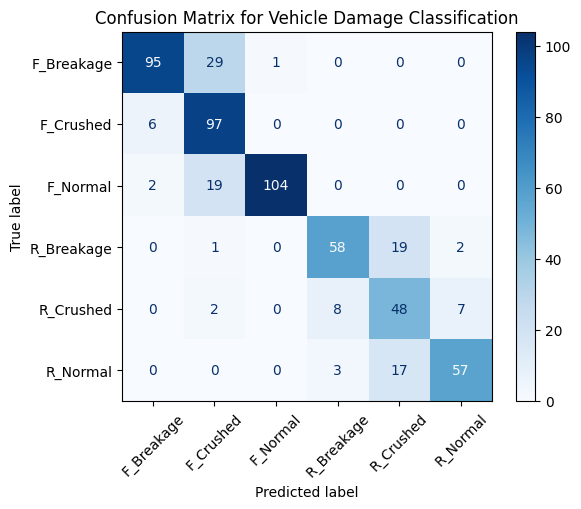

In [24]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(labels, predictions, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

In [25]:
torch.save(model.state_dict(), 'saved_model.pth')